# Introduction to the SpaCy pipeline

**Preface**

This introductory notebook represents a departure from the usual order in which one learns basic concepts in NLP. And, perhaps, in this LLM era, there is no usual progression anymore. Typically, one starts with words, tokens, n-grams, and then progresses to statistics for text classification, embeddings, and so forth. And we will get to these things in later notebooks. Pedagogically, **[Jurafsky and Martin (3rd. ed.)](https://web.stanford.edu/~jurafsky/slp3/)** sets a standard by which many follow. 

The challenge is learning NLP using an incremental and language-centered approach to NLP, while also committing to a toolchain centered on the spaCy library. **[SpaCy v.3](https://spacy.io)** provides a staggeringly rich ecosystem for NLP development suitable both for data science experimentation and enterprise deployment. When learning core operations in spaCy, the most natural place to start are spaCy container objects -- notably, **Doc (sequence of token objects)** and **Token** objects. Tokens themselves contain text annotations as processed by components in the spaCy pipeline. 

This notebook is designed to tackle linguistic concepts as we encounter them while starting from the most natural place to learn linguistic processing -- within the spaCy pipeline. Thus, the notebook is long and more involved than other spaCy-based NLP tutorials. Perhaps, think of it as a taste of NLP before we focus on NLP tasks and problem solving. 

**Learning objectives:**

- Core NLP components and spaCy pipleine
- Tokens and their attributes
- Language models as probability distributions
    - Bigram models
    - Neural language models
- Traditional NLP vs LLMs
    - Sentiment analysis
    - Summarization
- Flexible SpaCy pipelines incorporating LLM components


**Your goal** is to read this notebook and experiment as you like. As a student, **you are responsible for answering all questions in the reflection sections**. But I hope you think of your own questions and do some exploration.

I created this notebook in the [Solveit environment](https://solve.it.com), so there is much dialog where I work with AI to learn and expose capabilities in spaCy. Having such assistance makes it possible to do more than one might, otherwise. In a few places, I directly used AI provided code with some post-editing. And this will be obvious since I used Claude and it has a distinctive style.

## Load libraries and LLM keys

In [ ]:
# Dec 2025 Note: if you are on Colab, you will need to run this. Lisette relies on litellm 
# which has pinned a version of grpcio that is is lower than what is on colab. 

# Install lisette first (brings litellm + grpcio 1.67.x)
# Install lisette first
!pip install -q lisette

import sys

def fix_grpc_conflict_if_colab():
    """
    Colab ships grpcio-status >= 1.71 which conflicts with lisette's pinned grpcio.
    Downgrade ONLY when running inside Google Colab.
    """
    IN_COLAB = "google.colab" in sys.modules
    if IN_COLAB:
        print("⚙️  Colab detected — aligning grpc versions for lisette...")
        !pip install -q "grpcio<1.68.0" "grpcio-status<1.68.0"
        print("✓ grpc + grpcio-status pinned safely")
    else:
        print("No action needed (not running in Colab).")

fix_grpc_conflict_if_colab()

No action needed (not running in Colab).


In [ ]:
import spacy
import json
import os
import fastcore.tools as fc
import pandas as pd
import nltk
import orjson
from lisette import *

The spaCy library requires model downloads. We're using the English pipeline optimized for CPU (en_core_web_sm). When you visit this URL (https://spacy.io/models/en#en_core_web_sm), you'll find more information such as training data sources, type of text used for training, size, label schemas, metrics, and components available. We'll play around with most of these components over the next 6 weeks or so, before moving on to transformers.

In [ ]:
# load spacy

try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model en_core_web_sm loaded")
except OSError:
    print("spaCy model not found. Running download...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded after download!")

spaCy model en_core_web_sm loaded


I've put a lot of code in the namespace. It's worth knowing what has been added.

In [ ]:
[name for name in dir() if not name.startswith('_')]

The [listette library](https://lisette.answer.ai) wraps the litellm library and makes it possible for us to add models with API keys to this notebook. It has other useful functions that make it easy for us to "agentify" our notebooks and we'll play with those later, as well.

You don't need a subscription or API access, if you don't have it already. Use these notebooks as "read-only" for those sections. But if you do have a key, do use it!

- If you are Colab, enter your LLM keys into secrets
- On your local machine, use a .env file in the notebook environment
- If on solveit, keys are handled by default from secrets.

In [ ]:
#| eval: false

# set our models
# GPT-5 models only support temperature=1, so we need to pass this through lisette.
models = ["anthropic/claude-sonnet-4-5", "openai/gpt-5.1-codex"]

for model in models:
    chat = Chat(model, temp=1)
    res = chat("Please tell me about yourself in one brief sentence.")
    display(res)

I'm Claude, an AI assistant made by Anthropic, designed to be helpful, harmless, and honest in conversations.

<details>

- id: `chatcmpl-76b5e941-53da-42a2-a36d-467754e4466f`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=29, prompt_tokens=17, total_tokens=46, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

I’m ChatGPT, an AI language model created by OpenAI to assist with information and tasks.

<details>

- id: `chatcmpl-50a204de-3157-4772-91eb-024df5d92792`
- model: `gpt-5.1-codex`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=26, prompt_tokens=16, total_tokens=42, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

I assume the keys for these models came from my secrets in solveit. Is this true? Would this work the same in Google Colab or would I need to address in some other way? I need to use both, depending on whether my notebook runs in solveit or in Colab.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes, that's correct! In solveit, `lisette` automatically accesses your API keys from the secrets you've configured in your instance.

In Google Colab, you'd need to handle API keys differently. The common approaches are:

1. **Use Colab's Secrets feature** (recommended) - store keys in Colab's built-in secrets manager
2. **Set environment variables** manually in your notebook
3. **Use a `.env` file** (though this requires uploading it each session)

To make your code work in both environments, you could detect which platform you're on and handle keys accordingly. Would you like me to show you a pattern for doing this?

In [ ]:
#| eval: false

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import userdata
    os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')
    os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
    print("✓ Keys loaded from Colab secrets")
elif not IN_COLAB and os.path.exists('.env'):
    from dotenv import load_dotenv
    load_dotenv()
    print("✓ Keys loaded from .env file")
else:
    print("✓ Keys loaded from solveit secrets")

✓ Keys loaded from solveit secrets


## Part A - Test out a SpaCy pipeline (Tokens, POS, NER, and parse trees)


A **Doc** object is just a container for data. When we add structure to text, we'll be able to access annotations from it. We use the **nlp** object to provide the processing pipeline to create, enrich, and manage Docs. The first thing it does is run tokenization and then pipeline components.

We will use one Doc object per text. So for example, a news article from a collection of articles, would be contaied in a Doc object. Or an Amazon review would be contained within its own Doc object. We'll see why this helps later.

In [ ]:
# Note - surprisingly, doc prints back the text. dir(doc) shows us that this module has a __repr__ function which will print doc like a string.

# Sample text with multiple entities and interesting linguistic features
sample_text = """Dr. Sarah Chen joined Anthropic in San Francisco on January 15, 2024. She previously worked at Google Brain, where she led a team developing language models that could process over 100,000 tokens per second."""

# Process with spaCy
doc = nlp(sample_text)
doc

Dr. Sarah Chen joined Anthropic in San Francisco on January 15, 2024. She previously worked at Google Brain, where she led a team developing language models that could process over 100,000 tokens per second.

In [ ]:
[word.text for word in doc]

['Dr.',
 'Sarah',
 'Chen',
 'joined',
 'Anthropic',
 'in',
 'San',
 'Francisco',
 'on',
 'January',
 '15',
 ',',
 '2024',
 '.',
 'She',
 'previously',
 'worked',
 'at',
 'Google',
 'Brain',
 ',',
 'where',
 'she',
 'led',
 'a',
 'team',
 'developing',
 'language',
 'models',
 'that',
 'could',
 'process',
 'over',
 '100,000',
 'tokens',
 'per',
 'second',
 '.']

### Tokens and their Attributes

We'll spend a lot of time on **tokens** in the next couple weeks. **Tokenization** has enormous impact on the performance on NLP tasks.

Using the doc object, we can look at annotations on tokens. There are a very large number listed here: [spaCy token attributes](https://spacy.io/api/token#attributes) or use the help function, as below.

In [ ]:
help(doc[0])

In [ ]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Dr. compound Chen PROPN []
Sarah compound Chen PROPN []
Chen nsubj joined VERB [Dr., Sarah]
joined ROOT joined VERB [Chen, Anthropic, in, on, .]
Anthropic dobj joined VERB []
in prep joined VERB [Francisco]
San compound Francisco PROPN []
Francisco pobj in ADP [San]
on prep joined VERB [January]
January pobj on ADP [15, ,, 2024]
15 nummod January PROPN []
, punct January PROPN []
2024 nummod January PROPN []
. punct joined VERB []
She nsubj worked VERB []
previously advmod worked VERB []
worked ROOT worked VERB [She, previously, at, .]
at prep worked VERB [Brain]
Google compound Brain PROPN []
Brain pobj at ADP [Google, ,, led]
, punct Brain PROPN []
where advmod led VERB []
she nsubj led VERB []
led relcl Brain PROPN [where, she, team]
a det team NOUN []
team dobj led VERB [a, developing]
developing acl team NOUN [models]
language compound models NOUN []
models dobj developing VERB [language, process]
that nsubj process VERB []
could aux process VERB []
process relcl models NOUN [that

In [ ]:
# Claude helped me create a table of tokens with their attributes
# It's just a prettier version than the above

token_data = []
for token in doc:
    token_data.append({
        "Token": token.text,
        "Lemma": token.lemma_,
        "POS": token.pos_,
        "Tag": token.tag_,
        "Dep": token.dep_,
        "Is_Stop": token.is_stop
    })

token_df = pd.DataFrame(token_data)
print("\n📊 TOKEN ANALYSIS (first 15 tokens)")
print("="*70)
print(token_df.head(15).to_string(index=False))

print("\n\n💡 Expected Observation:")
print("   - Notice how 'joined' has lemma 'join' (verb normalization)")
print("   - 'Dr.' is tagged as NNP (proper noun) despite the period")
print("   - Stop words like 'in', 'on', 'a' are marked True for Is_Stop")


📊 TOKEN ANALYSIS (first 15 tokens)
    Token     Lemma   POS Tag      Dep  Is_Stop
      Dr.       Dr. PROPN NNP compound    False
    Sarah     Sarah PROPN NNP compound    False
     Chen      Chen PROPN NNP    nsubj    False
   joined      join  VERB VBD     ROOT    False
Anthropic Anthropic PROPN NNP     dobj    False
       in        in   ADP  IN     prep     True
      San       San PROPN NNP compound    False
Francisco Francisco PROPN NNP     pobj    False
       on        on   ADP  IN     prep     True
  January   January PROPN NNP     pobj    False
       15        15   NUM  CD   nummod    False
        ,         , PUNCT   ,    punct    False
     2024      2024   NUM  CD   nummod    False
        .         . PUNCT   .    punct    False
      She       she  PRON PRP    nsubj     True


💡 Expected Observation:
   - Notice how 'joined' has lemma 'join' (verb normalization)
   - 'Dr.' is tagged as NNP (proper noun) despite the period
   - Stop words like 'in', 'on', 'a' are marke

While **Part-of-Speech (POS)**, **syntactic (constituent) categories (Tag)**, and **Dependency relations (Dep)** are important concepts. We won't go into in any depth on this right now. This lab gives you an introduction to these concepts because of the importance of token level annotations in SpaCy.

Think of tokens as the most basic (meaningful) unit that you will focus on in NLP. The first stage in NLP pre-processing is usually tokenization to break up text into the smaller bits that we process. As objects, they have the potential to carry a lot of information in the spaCy pipeline. We're going to briefly look at the sorts of information they carry in this lab. Don't worry about the details... this is an introduction to terms you will become more familiar with.

### Lemmas and stopwords

Tell me what lemmas and stop words are and how they might be used in NLP tasks?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! Let me explain these two important concepts:

**Lemmas** are the base or dictionary form of a word. For example:
- "joined" → "join"
- "running" → "run"  
- "better" → "good"

This normalization is useful because it lets you treat different forms of the same word as equivalent. For instance, if you're analyzing sentiment in reviews, you'd want "loved," "loving," and "loves" to all be recognized as the same concept.

**Stop words** are common words that often don't carry much meaning on their own, like "the," "is," "at," "in," "a." You can see in your token table that words like "in" and "on" are marked as stop words.

They're often filtered out in tasks like:
- Document classification (where "the" appears everywhere and doesn't help distinguish topics)
- Keyword extraction (you want meaningful words, not "and" or "of")

However, stop words ARE important for some tasks—like machine translation or question answering, where "not" or "who" can completely change meaning!

Looking at your sample text, can you spot why lemmatization might be helpful for analyzing this text? What if you wanted to count how many times people "work" at different companies across many documents?

### Part-of-Speech Tagging

What do you know about POS tags used by SpaCy? Is there a good reference?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

SpaCy uses two types of POS tags:

1. **Coarse-grained tags** (`token.pos_`) - Universal POS tags from the Universal Dependencies project. These are standardized across languages (like NOUN, VERB, ADJ, etc.)

2. **Fine-grained tags** (`token.tag_`) - Language-specific tags. For English, these are Penn Treebank tags (like NNP, VBD, JJ, etc.)

The best references are:

- [**Universal POS tags**](https://universaldependencies.org/u/pos/)
- [**Penn Treebank tags**](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
- [**SpaCy's own documentation**](https://spacy.io/api/annotation#pos-tagging)

You can also see what tags are available in your loaded model by checking `nlp.get_pipe("tagger").labels`.

Would you like to explore the tags in your current doc, or see what your model supports?

Give me a reference table for those that I am seeing.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's a quick reference for the tags appearing in your token data:

**POS Tags (Universal):**
- `PROPN` - Proper noun (Sarah, Chen, Anthropic, San Francisco)
- `VERB` - Verb (joined)
- `ADP` - Adposition/preposition (in, on)
- `NUM` - Number (15, 2024)
- `PUNCT` - Punctuation (., ,)
- `PRON` - Pronoun (She)

**Penn Treebank Tags (detailed):**
- `NNP` - Proper noun, singular (Dr., Sarah, Chen)
- `VBD` - Verb, past tense (joined)
- `IN` - Preposition or subordinating conjunction (in, on)
- `CD` - Cardinal number (15, 2024)
- `PRP` - Personal pronoun (She)

**Dependency Labels:**
- `nsubj` - Nominal subject (Chen is the subject of "joined")
- `dobj` - Direct object (Anthropic is what was joined)
- `compound` - Compound modifier (Dr. + Sarah + Chen)
- `prep` - Prepositional modifier (in, on)
- `pobj` - Object of preposition (Francisco, January)
- `nummod` - Numeric modifier (15 modifies January)
- `ROOT` - Root of the sentence (joined)

Would you like to see these applied to your data, or explore any specific tag type in more detail?

Tell me how SpaCy's POS tagger works?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

SpaCy's POS tagger uses a neural network model trained on annotated text data. Here's how it works:

**Training:** The model learns patterns from large corpora (like OntoNotes for English) where words are already tagged with their parts of speech. It learns contextual clues—for example, that a word after "the" is likely a noun.

**Prediction:** When you process text with `nlp(text)`, the tagger looks at each token in context (surrounding words, word shape, prefixes/suffixes) and predicts the most likely POS tag using the trained neural network.

**Architecture:** Modern SpaCy models (v3+) use transformer-based or CNN-based architectures. The small model you're using (`en_core_web_sm`) uses a more compact architecture for speed.

The tagger is one component in the processing pipeline. You can see your pipeline components with:

```python
nlp.pipe_names
```

Want to try that to see what other components are running when you call `nlp(text)`?

In [ ]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

We're using spaCy version 3 which includes transformer models. Tok2vec is a model that turns tokens to vectors. We'll get to what that means later, but its useful to know that the (POS) tagger is a classifier that takes a vector as input and predicts a POS label. 

What's really neat about the "token-to-vector" model is that it's outputs can be used between multiple components such as the (POS) Tagger and Dependency Parser.

We'll look at dependency parsing more below.

### Named Entities

According to the [SpaCy model reference](https://spacy.io/models), the Named Entity Recognition (NER) component also uses vectors as input. It is configurable to use its own Tok2Vec model, though by default, uses the pipeline Tok2Vec model. SpaCy is extremely configurable and you can turn components on and off, as long as you are paying attention to dependencies.

NER uses all sorts of features as context. For example, it uses punctuation to signal clause boundaries, abbreviations, etc. It also uses lexical features and contextual token features such as neighboring tokens, subword patterns, and other contextual clues. It does not rely on POS tags or dependency parses.

In [ ]:
# Visualize entities (Colab-friendly)
from spacy import displacy
from IPython.display import display, HTML

# Render entities
html = displacy.render(doc, style="ent", jupyter=False)
display(HTML(html))

How can we use POS tags in NLP tasks?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

POS tags are useful building blocks for many NLP tasks:

**1. Information Extraction** - You can filter for specific patterns. For example, finding all noun phrases (sequences of adjectives + nouns) to extract key concepts, or finding verb-object pairs to understand actions.

**2. Text Preprocessing** - You might keep only nouns and verbs for topic modeling, or remove everything except proper nouns to find names and places.

**3. Disambiguation** - The word "book" could be a noun (read a book) or verb (book a flight). POS tags help distinguish meaning.

**4. Feature Engineering** - For classification tasks, POS tag distributions can be features. Academic writing has different POS patterns than casual speech.

Looking at your `doc`, what if you wanted to extract just the organizations mentioned? You could filter for proper nouns (`PROPN`), but notice "Google Brain" is tagged as `FAC` (facility) in the NER output. 

Would you like to try writing some code to extract entities or tokens based on their POS tags?

In [ ]:
spacy.explain("FAC")

'Buildings, airports, highways, bridges, etc.'

### Labels can be wrong (optional)

This section is very much optional. But it will give you insight into how I used AI to help me learn how to dig deeper into the SpaCy API completely unfamiliar to me. What you don't see are all the cells I deleted, by going down unhelpful alleys. In some cases, the AI had difficulty with getting to what I wanted with the spaCy API because I'm trying to use less documented and used functionality in the API.

How can we gain insight into why "Google Brain" is tagged as GPE?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

There are a few ways to investigate why SpaCy tagged "Google Brain" as FAC (Facilities) instead of ORG (Organization):

**1. Check what SpaCy actually tagged it as:**
```python
for ent in doc.ents:
    if "Google" in ent.text or "Brain" in ent.text:
        print(f"Text: '{ent.text}' | Label: {ent.label_} | Explanation: {spacy.explain(ent.label_)}")
```

**2. Look at the token-level predictions:**
```python
for token in doc:
    if token.text in ["Google", "Brain"]:
        print(f"Token: {token.text} | ENT_IOB: {token.ent_iob_} | ENT_TYPE: {token.ent_type_}")
```

The `ent_iob_` tells you if it's at the Beginning, Inside, or Outside of an entity.

Which approach would you like to try first?

In [ ]:
for token in doc:
    if token.text in ["Google", "Brain"]:
        print(f"Token: {token.text} | ENT_IOB: {token.ent_iob_} | ENT_TYPE: {token.ent_type_}")

Token: Google | ENT_IOB: B | ENT_TYPE: FAC
Token: Brain | ENT_IOB: I | ENT_TYPE: FAC


Below is a bit of a tangent and just an example of where you can go when you experiment with AI's help. "Google Brain" is clearly not a 'facility.' It's an 'organization'. I started to play to see what the surrounding tags looked like. This turned out to be quite difficult (even with AI helping), so only took this so far.

Can we access tag probabilities?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes! SpaCy's NER component can give you probabilities for entity predictions. You need to access the pipeline component directly:

```python
# Get the NER component
ner = nlp.get_pipe("ner")

# Get beam search results with probabilities
beams = nlp.pipe_labels["ner"]
print("Available labels:", beams)
```

However, the standard `en_core_web_sm` model doesn't store full probability distributions by default. To get detailed probabilities, you'd need to:

1. Use `nlp.beam_parse()` for beam search results, or
2. Access the internal scores (requires going deeper into the model)

Would you like to try accessing the beam search results, or would you prefer to explore other ways to understand why the model made this prediction?

In [ ]:
# Get the NER component
ner = nlp.get_pipe("ner")

# Get beam search results with probabilities
beams = nlp.pipe_labels["ner"]
print("Available labels:", beams)

Available labels: ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']


In [ ]:
# Run NER in beam mode
beams = nlp.get_pipe("ner").beam_parse(
    [doc],
    beam_width=4,
    beam_density=0.0001
)

# The beam_parse() method returns a list of beam objects (one per document).

Tell me about the beam object, beam parameters, and beam histories.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The beam search returns structured results that let you explore alternative predictions:

**Beam object structure:**
- `beams` is a list with one entry per document
- Each beam contains the top-k sequences of entity predictions

**Key parameters you used:**
- `beam_width=4` - Keeps the top 4 most likely prediction sequences at each step
- `beam_density=0.0001` - Controls pruning (lower = more aggressive pruning of unlikely paths)

**Accessing beam histories:**
You can iterate through the beam to see alternative entity taggings.

This shows you the different ways the model considered tagging entities.

Want to try running that code to see what alternative predictions the model considered for "Google Brain"?

In [ ]:
beam = beams[0]
print(f"Number of candidates: {len(beam)}")
print(f"Score of best sequence: {beam.score}")

Number of candidates: 4
Score of best sequence: 468.5957946777344


In [ ]:
beam.histories

[[73,
  2,
  38,
  73,
  73,
  73,
  3,
  39,
  73,
  1,
  19,
  19,
  37,
  73,
  73,
  73,
  73,
  73,
  12,
  48,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  59,
  73,
  73,
  68,
  73],
 [73,
  2,
  38,
  73,
  56,
  73,
  3,
  39,
  73,
  1,
  19,
  19,
  37,
  73,
  73,
  73,
  73,
  73,
  12,
  48,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  59,
  73,
  73,
  68,
  73],
 [73,
  2,
  38,
  73,
  57,
  73,
  3,
  39,
  73,
  1,
  19,
  19,
  37,
  73,
  73,
  73,
  73,
  73,
  12,
  48,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  59,
  73,
  73,
  68,
  73],
 [73,
  2,
  38,
  73,
  60,
  73,
  3,
  39,
  73,
  1,
  19,
  19,
  37,
  73,
  73,
  73,
  73,
  73,
  12,
  48,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  73,
  59,
  73,
  73,
  68,
  73]]

What do these numbers stand for?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

These numbers are **action IDs** representing NER tagging decisions at each token position. Each number maps to a specific action like "Begin-PERSON", "Inside-FAC", "Outside", etc.

You can decode them using the NER component's move names:

```python
ner = nlp.get_pipe("ner")
for i, name in enumerate(ner.move_names):
    print(f"{i}: {name}")
```

This will show you the mapping. For example, `73` likely means "O" (Outside/no entity), and the different numbers at position 4 (where "Anthropic" is) show alternative entity predictions the model considered.

Want to run that to see the full mapping?

In [ ]:
ner = nlp.get_pipe("ner")
move_list = []
for i, name in enumerate(ner.move_names):
    move_list.append((i, name))
    #print(f"{i}: {name}")
move_list.append((73,'OUTSIDE'))

In [ ]:
move_list

[(0, 'B-ORG'),
 (1, 'B-DATE'),
 (2, 'B-PERSON'),
 (3, 'B-GPE'),
 (4, 'B-MONEY'),
 (5, 'B-CARDINAL'),
 (6, 'B-NORP'),
 (7, 'B-PERCENT'),
 (8, 'B-WORK_OF_ART'),
 (9, 'B-LOC'),
 (10, 'B-TIME'),
 (11, 'B-QUANTITY'),
 (12, 'B-FAC'),
 (13, 'B-EVENT'),
 (14, 'B-ORDINAL'),
 (15, 'B-PRODUCT'),
 (16, 'B-LAW'),
 (17, 'B-LANGUAGE'),
 (18, 'I-ORG'),
 (19, 'I-DATE'),
 (20, 'I-PERSON'),
 (21, 'I-GPE'),
 (22, 'I-MONEY'),
 (23, 'I-CARDINAL'),
 (24, 'I-NORP'),
 (25, 'I-PERCENT'),
 (26, 'I-WORK_OF_ART'),
 (27, 'I-LOC'),
 (28, 'I-TIME'),
 (29, 'I-QUANTITY'),
 (30, 'I-FAC'),
 (31, 'I-EVENT'),
 (32, 'I-ORDINAL'),
 (33, 'I-PRODUCT'),
 (34, 'I-LAW'),
 (35, 'I-LANGUAGE'),
 (36, 'L-ORG'),
 (37, 'L-DATE'),
 (38, 'L-PERSON'),
 (39, 'L-GPE'),
 (40, 'L-MONEY'),
 (41, 'L-CARDINAL'),
 (42, 'L-NORP'),
 (43, 'L-PERCENT'),
 (44, 'L-WORK_OF_ART'),
 (45, 'L-LOC'),
 (46, 'L-TIME'),
 (47, 'L-QUANTITY'),
 (48, 'L-FAC'),
 (49, 'L-EVENT'),
 (50, 'L-ORDINAL'),
 (51, 'L-PRODUCT'),
 (52, 'L-LAW'),
 (53, 'L-LANGUAGE'),
 (54, 'U-OR

In [ ]:
history_0 = [73, 2, 38, 73, 73, 73, 3, 39, 73, 1, 19, 19, 37, 73, 73, 73, 73, 73, 12, 48, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 59, 73, 73, 68, 73]


In [ ]:
for action_id in history_0:
    print(move_list[action_id][1])

OUTSIDE
B-PERSON
L-PERSON
OUTSIDE
OUTSIDE
OUTSIDE
B-GPE
L-GPE
OUTSIDE
B-DATE
I-DATE
I-DATE
L-DATE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
B-FAC
L-FAC
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
OUTSIDE
U-CARDINAL
OUTSIDE
OUTSIDE
U-ORDINAL
OUTSIDE


Using this approach of matching the beam.history lists and move_list, help me loop over beam.histories and print a table using pandas to see the sequence for each history.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I can help you create a table showing each beam history. Here's an approach:

```python
import pandas as pd

# Decode all histories
decoded_histories = []
for i, history in enumerate(beam.histories):
    decoded = [move_list[action_id][1] for action_id in history]
    decoded_histories.append({
        'History': i,
        'Sequence': ' → '.join(decoded)
    })

df = pd.DataFrame(decoded_histories)
print(df)
```

This will give you a row for each alternative prediction sequence. If you want to see them side-by-side by token position instead, we could transpose it. Which format would be more useful for you?

In [ ]:
import pandas as pd

# Decode all histories
decoded_histories = []
for i, history in enumerate(beam.histories):
    decoded = [move_list[action_id][1] for action_id in history]
    decoded_histories.append({
        'History': i,
        'Sequence': ' → '.join(decoded)
    })

df = pd.DataFrame(decoded_histories)
print(df)

   History                                           Sequence
0        0  OUTSIDE → B-PERSON → L-PERSON → OUTSIDE → OUTS...
1        1  OUTSIDE → B-PERSON → L-PERSON → OUTSIDE → U-PE...
2        2  OUTSIDE → B-PERSON → L-PERSON → OUTSIDE → U-GP...
3        3  OUTSIDE → B-PERSON → L-PERSON → OUTSIDE → U-NO...


I'd like to see the whole sequence. Maybe by column side-by-side?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good idea! Let's create a table where each column is a beam history and each row is a token position:

```python
# Create a dictionary where each history is a column
beam_comparison = {}
for i, history in enumerate(beam.histories):
    decoded = [move_list[action_id][1] for action_id in history]
    beam_comparison[f'Beam_{i}'] = decoded

df_beams = pd.DataFrame(beam_comparison)
df_beams.index.name = 'Token_Position'
print(df_beams)
```

This will show you all four alternative sequences aligned by token position. Would you like to try running this?

In [ ]:
# Create a dictionary where each history is a column
beam_comparison = {}
for i, history in enumerate(beam.histories):
    decoded = [move_list[action_id][1] for action_id in history]
    beam_comparison[f'Beam_{i}'] = decoded

df_beams = pd.DataFrame(beam_comparison)
df_beams.index.name = 'Token_Position'
print(df_beams)

                    Beam_0      Beam_1      Beam_2      Beam_3
Token_Position                                                
0                  OUTSIDE     OUTSIDE     OUTSIDE     OUTSIDE
1                 B-PERSON    B-PERSON    B-PERSON    B-PERSON
2                 L-PERSON    L-PERSON    L-PERSON    L-PERSON
3                  OUTSIDE     OUTSIDE     OUTSIDE     OUTSIDE
4                  OUTSIDE    U-PERSON       U-GPE      U-NORP
5                  OUTSIDE     OUTSIDE     OUTSIDE     OUTSIDE
6                    B-GPE       B-GPE       B-GPE       B-GPE
7                    L-GPE       L-GPE       L-GPE       L-GPE
8                  OUTSIDE     OUTSIDE     OUTSIDE     OUTSIDE
9                   B-DATE      B-DATE      B-DATE      B-DATE
10                  I-DATE      I-DATE      I-DATE      I-DATE
11                  I-DATE      I-DATE      I-DATE      I-DATE
12                  L-DATE      L-DATE      L-DATE      L-DATE
13                 OUTSIDE     OUTSIDE     OUTSIDE     

In [ ]:
beam = beams[0]
beam.scores


[468.5957946777344, 467.2428283691406, 467.0743713378906, 465.2885437011719]

Is this like dynamic programming where we look at the best possible path through the entire sequence?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes, exactly! Beam search is very similar to dynamic programming approaches like Viterbi decoding.

The key idea is that at each token position, the model considers multiple possible tagging sequences and keeps only the top-k (beam_width=4 in your case) most promising ones based on cumulative scores. It's pruning the search space while still exploring alternatives.

Notice in your table that the four beams only differ at position 4 (where "Anthropic" is). The model considered tagging it as:
- OUTSIDE (not an entity)
- U-PERSON (single-token person)
- U-GPE (single-token geo-political entity)
- U-NORP (single-token nationality/religious/political group)

All other positions have the same predictions across beams. The scores show Beam_0 (OUTSIDE) won with 468.6, just slightly ahead of the alternatives.

Does this help explain why "Google Brain" was tagged as FAC across all beams?

Let's play around with 'Google Brain' to look at some other sentences. We want to experiment and see under what sentence contexts it is tagged correctly as an ORG.

In [ ]:
doc1 = nlp("She joined Google Brain as an engineer")
doc2 = nlp("Google Brain is a research organization")
doc3 = nlp("She worked at the company Google Brain")

# Render entities
html = displacy.render(doc3, style="ent", jupyter=False)
display(HTML(html))

Quick note: I learned that getting a sequence of NER tags from each possible parse is actually pretty hard since there is little documentation. Like the POS tagger, SpaCy makes it easy to get the "best sequence" for it's training data, but not alternates. To improve, we will learn to customize NER on our data sets. That's something we will play with later.

## Part B - Dependency Parsing

You have been given some [basic study material on a theory of language structure based on "X-bar" theory](https://socialsci.libretexts.org/Courses/Canada_College/ENGL_LING_200%3A_Introduction_to_Linguistics/05%3A_Phrases-_Syntax/5.03%3A_Phrase_Structure_Rules_X-Bar_Theory_and_Constituency), which is a kind of **constituent parsing**. This kind of parsing has a lot of positives. It can tell you about where noun and verb phrases begin and end because it has rich, hierarchical structure. You can plugin a constituent parser into spaCy, but it's not the default.

SpaCy chose to implement dependency parsing because it's faster (linear time), low memory, robust token-centric, and works across many languages (i.e. cross-lingual). Like constituent parsing, it's also usedful for downstream tasks. Your linguistics book doesn't talk about dependency parsing, so we'll draw from Jurafsky and Martin and touch on it in this notebook.

Note, it's not important to know the details here. Focus on why SpaCy has a dependency parser out of the box -- why it might be useful -- and that it works at the token level.


In [ ]:
# Visualize entities (Colab-friendly)
from spacy import displacy
from IPython.display import display, HTML

options = {
    "distance": 90,   # arc length
    "compact": False,
    "bg": "#ffffff",
    "color": "#000000",
    "font": "Arial"
}

# Render entities. We need to break out by sentence since this will take a lot of horizontal space, otherwise.
html = displacy.render(
    list(doc.sents),   # important: avoids cramped multi-sentence trees
    style="dep",
    options=options,
    jupyter=False
)
display(HTML(html))

Tell me how to read this dependency chart. Maybe use the first sentence as an example.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Looking at the first sentence's dependency chart, here's how to read it:

**The arrows show relationships between words**, where:
- The arrow points FROM a dependent word TO its head (the word it modifies or relates to)
- The label on the arrow tells you the type of relationship

**Example from "Dr. Sarah Chen joined Anthropic...":**

- "Dr." and "Sarah" both have arrows pointing to "Chen" with label `compound` - they're parts of the compound name
- "Chen" has an arrow to "joined" labeled `nsubj` (nominal subject) - Chen is who performed the action
- "Anthropic" points to "joined" with `dobj` (direct object) - Anthropic is what was joined
- "in" points to "joined" with `prep` (prepositional modifier)
- "Francisco" points to "in" with `pobj` (object of preposition)

**The ROOT** is "joined" - it's the main verb with no arrow pointing away from it.

Try tracing one relationship yourself. Can you explain what the arrow from "San" to "Francisco" means?

This is what a dependency parse looks like compared to a syntax tree constituent analysis and is from [Chapter 19 of Jurafsky & Martin](https://web.stanford.edu/~jurafsky/slp3/19.pdf). Arguments to relations are heads and dependents. Heads are the organizing word and dependents are like modifiers. These are labeled with grammatical functions like "Nominal subject" or "Direct object." 

For example, (**NSUBJ**) **United** canceled the (**DOBJ**) **flight**.

The Universal Dependencies project is a community effort to align a grammar across more than 100 language with an inventory of 37 dependency relations. 

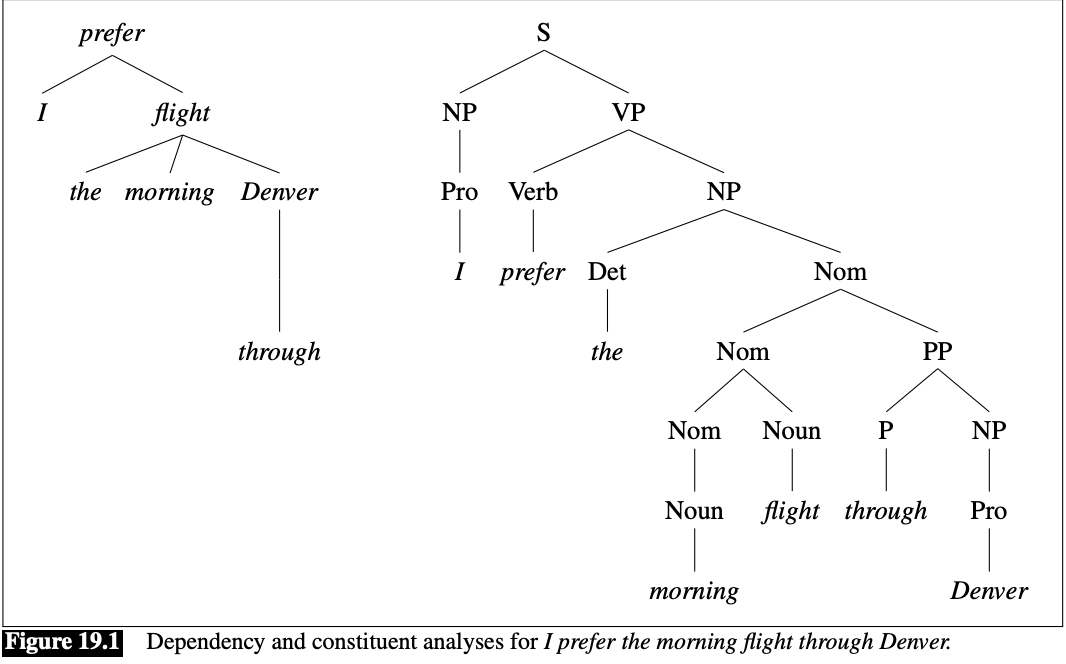


Notably, dependency parsing answers questions like:
- who did what to whom?
- what modifies what?
- what organizations below to which phrase?

Unlike consituency parsers which use the **sentence** as the root of the tree, dependency grammars place the main **verb** as the head of a clause (sentence embedded in a larger sentence). 

So in our clause "she previously **worked** at Google Brain", 'worked' is the root that everything depends on.

- **she** is "who did it"
- **previously** is "when"
- at **Google Brain** is "where" (oblique argument)

Tell me about the dependency parser in spaCy. Is it also based on a sequence of span probabilities like POS

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

SpaCy's dependency parser works differently from POS tagging. Instead of assigning labels to individual tokens, it predicts **relationships between tokens** (which token is the head of which other token, and what type of dependency).

The parser uses a **transition-based approach**:
- It processes the sentence incrementally, making a series of decisions (transitions)
- At each step, it can perform actions like "attach this word to that word with label X"
- It builds up the parse tree through these sequential decisions

Like NER, it can use beam search to explore multiple parsing paths and find the most probable complete parse tree.

The key difference: POS assigns one label per token independently, while dependency parsing creates a **structure** where every token (except the root) must connect to exactly one head token.

Would you like to explore how the parser handles ambiguous sentences, or see what transitions it makes?

This diagram is from Jurafsky & Martin Chapter 19.2 and is an illustration of **transition-based** parsing. It demonstrates **shift-reduce parsing** where we have a stack on which we build the parse, a buffer of tokens to parse, and a parser which takes actions on the prase via a predictor called an oracle. It can explore multiple paths, when doing so - though, that will slow this process down.

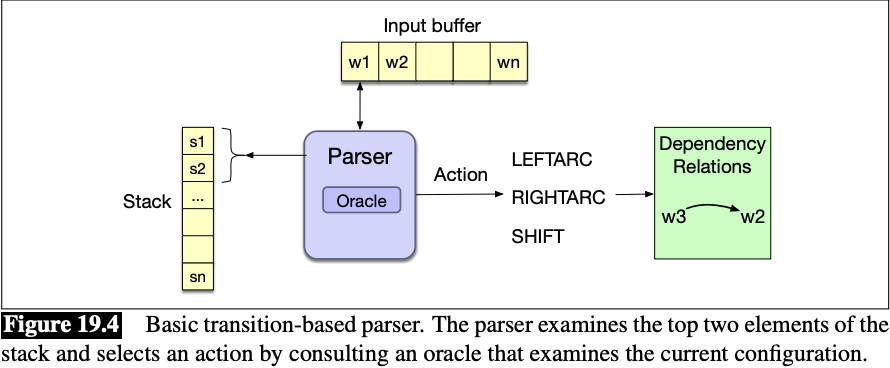

The parser walks through the sentence left-to-right, successively shifting items
from the buffer onto the stack. At each time point we examine the top two elements
on the stack, and the oracle makes a decision about what transition to apply to build the parse. 

These are the tree transition operations on the top two elements of the stack:

1. **LEFTARC**: Assert a head-dependent relation between the word at the top of
the stack and the second word; remove the second word from the stack.

2. **RIGHTARC**: Assert a head-dependent relation between the second word on
the stack and the word at the top; remove the top word from the stack.

3. **SHIFT**: Remove the word from the front of the input buffer and push it onto
the stack.

This is a greedy algorithm - the oracle provides a single choice at each step and the parser proceeds with that choice and no other options are explored. There is no backtracking and a single parse is returned in the end.

Think of it this way, the Oracle is a trained supervised algorithm that makes a decision over two tokens until there are no more rules to apply. It decides if it will shift a word onto the stack, or if it will assert a relationship (left or right) between two tokens. Recall, **every token must connect to exactly one head token.** 

Lets walk through an example.


Here's an example from J&M Chapter 19.

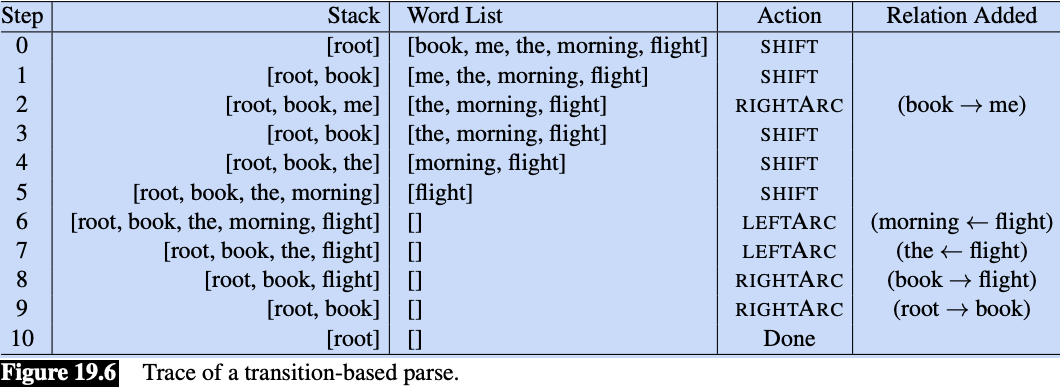

You can see that every stage the algorithm is looking for one head token and one dependent token until there are none left.


Below, we will tell SpaCy to give us the top three parses. Generally, we want a beam_width of 1 (one parse), because this is much faster.

In [ ]:

parser = nlp.get_pipe("parser")
beams = parser.beam_parse([doc], beam_width=3)

In [ ]:
head_scores, label_scores = parser.scored_parses(beams)
print(f"Number of alternatives: {len(beams[0].histories)}")
print(f"Probabilities: {beams[0].probs}")

Number of alternatives: 3
Probabilities: [0.7982435893632595, 0.17826448047596988, 0.023491930160770638]


Tell me what these scores mean?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The `beams[0].probs` shows the probabilities for the top 3 complete dependency parse trees:

- **79.8%** - The parse tree SpaCy chose (most probable)
- **17.8%** - Second-best alternative parse
- **2.3%** - Third-best alternative

The `head_scores` and `label_scores` from `scored_parses()` give you more detailed information about individual attachment decisions and dependency labels for each token in each parse.

Want to look at what's actually different between these three parse trees? We could decode the histories to see where they disagree.

## Part C - Language Modeling as Probability Distributions

The first thing we're going to do is look at a simple bigram model. A bigram is a pair of consecutive units. These models perform surprisingly well! You can also build trigram models -- three consecutive units, and four-gram models. All are simply types of 'n-gram' models.

So, for example, 

- unigram - 'the'
- bigram - 'the man'
- trigram - 'the man with'
- 4-gram - 'the man with the'

The larger the chunk, the more context. We'll look at n-grams more in depth later this semester.


In [ ]:
from collections import defaultdict, Counter
import random

In [ ]:
# A small corpus for our bigram model
corpus = """
I saw the man with the telescope yesterday.
I saw the bird with my binoculars.
The man with the hat waved at me.
I watched the show with great interest.
The telescope with the red lens was expensive.
I observed the stars with the telescope.
The bird with colorful feathers flew away.
She saw him with her own eyes.
The man with the briefcase left early.
I spotted the deer with the binoculars.
"""

In [ ]:
class BigramLM:
    """A simple bigram language model."""
    
    def __init__(self):
        self.bigram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()
        
    def train(self, text):
        """Train on a corpus of text."""
        # Simple tokenization
        tokens = text.lower().replace('.', ' .').replace(',', ' ,').split()
        
        # Count unigrams
        self.unigram_counts.update(tokens)
        
        # Count bigrams
        for i in range(len(tokens) - 1):
            self.bigram_counts[tokens[i]][tokens[i+1]] += 1
            
        print(f"Trained on {len(tokens)} tokens, {len(self.bigram_counts)} unique contexts")
    
    def get_next_word_probs(self, context_word, top_k=5):
        """Get probability distribution over next words given context."""
        context_word = context_word.lower()
        if context_word not in self.bigram_counts:
            return []
        
        counts = self.bigram_counts[context_word]
        total = sum(counts.values())
        
        probs = [(word, count/total) for word, count in counts.most_common(top_k)]
        return probs
    
    def score_sequence(self, words):
        """Score a sequence of words (log probability)."""
        import math
        words = [w.lower() for w in words]
        log_prob = 0
        for i in range(len(words) - 1):
            context = words[i]
            next_word = words[i+1]
            if context in self.bigram_counts and next_word in self.bigram_counts[context]:
                prob = self.bigram_counts[context][next_word] / sum(self.bigram_counts[context].values())
                log_prob += math.log(prob)
            else:
                log_prob += math.log(1e-6)  # Smoothing for unseen
        return log_prob

In [ ]:
# Train our bigram model
bigram_lm = BigramLM()
bigram_lm.train(corpus)

Trained on 83 tokens, 39 unique contexts


In [ ]:
# Explore next-word probabilities from our bigram model
print("\n📊 BIGRAM MODEL: Next-word probabilities")
print("="*50)

test_contexts = ["the", "with", "saw", "man"]

for context in test_contexts:
    probs = bigram_lm.get_next_word_probs(context, top_k=5)
    print(f"\nAfter '{context}':")
    for word, prob in probs:
        print(f"   {word:15} {prob:.3f} {'█' * int(prob * 20)}")

print("\n💡 Expected Observation:")
print("   - Limited vocabulary (only words seen in training)")
print("   - Only looks at ONE previous word (no long-range context)")
print("   - Sparse: many word pairs never seen → zero probability")


📊 BIGRAM MODEL: Next-word probabilities

After 'the':
   man             0.200 ████
   telescope       0.200 ████
   bird            0.133 ██
   hat             0.067 █
   show            0.067 █

After 'with':
   the             0.600 ████████████
   my              0.100 ██
   great           0.100 ██
   colorful        0.100 ██
   her             0.100 ██

After 'saw':
   the             0.667 █████████████
   him             0.333 ██████

After 'man':
   with            1.000 ████████████████████

💡 Expected Observation:
   - Limited vocabulary (only words seen in training)
   - Only looks at ONE previous word (no long-range context)
   - Sparse: many word pairs never seen → zero probability


What do you think probabilities would look like with these contexts?
test_contexts = ["the", "quick", "brown", "fox"]

Now let's see how a neural model handles the tax of next-token probabilities.

In [ ]:
#| eval: false

# ============================================================
# UNIFIED INTERFACE FOR NEXT-TOKEN PROBABILITIES
# ============================================================
# This works with:
#   1. LOCAL model (always available, no API key needed)
#   2. OpenAI GPT (if OPENAI_API_KEY present)
#   3. Gemini (limited logprob support)
# ============================================================

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

# Load local model (distilgpt2 - small and fast)
print("Loading local language model (distilgpt2)...")
local_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
local_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
local_model.eval()
print("✅ Local model loaded!")

def get_next_token_distribution_local(prompt, k=10):
    """
    Get top-k next token probabilities using local model.
    Returns: list of (token_string, probability) tuples
    """
    inputs = local_tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = local_model(**inputs)
        # Get logits for the last position
        next_token_logits = outputs.logits[0, -1, :]
        # Convert to probabilities
        probs = F.softmax(next_token_logits, dim=-1)
        # Get top-k
        top_probs, top_indices = torch.topk(probs, k)
        
    results = []
    for prob, idx in zip(top_probs.tolist(), top_indices.tolist()):
        token = local_tokenizer.decode([idx])
        results.append((token, prob))
    
    return results

def score_continuation_local(prompt, continuation):
    """
    Score a continuation given a prompt using teacher forcing.
    Returns: (sum_log_prob, avg_log_prob, num_tokens)
    """
    import math
    
    full_text = prompt + continuation
    prompt_ids = local_tokenizer(prompt, return_tensors="pt")["input_ids"]
    full_ids = local_tokenizer(full_text, return_tensors="pt")["input_ids"]
    
    prompt_len = prompt_ids.shape[1]
    
    with torch.no_grad():
        outputs = local_model(full_ids)
        logits = outputs.logits[0]  # [seq_len, vocab_size]
        
    # Score each token in the continuation
    log_probs = []
    for i in range(prompt_len - 1, full_ids.shape[1] - 1):
        next_token_id = full_ids[0, i + 1].item()
        token_logits = logits[i]
        token_probs = F.softmax(token_logits, dim=-1)
        log_prob = math.log(token_probs[next_token_id].item() + 1e-10)
        log_probs.append(log_prob)
    
    sum_log_prob = sum(log_probs)
    avg_log_prob = sum_log_prob / len(log_probs) if log_probs else 0
    
    return sum_log_prob, avg_log_prob, len(log_probs)

# Create unified interface
def get_next_token_distribution(prompt, k=10, provider="auto"):
    """Get next-token distribution from best available provider."""
    if provider == "auto":
        provider = "local"  # Local is most reliable for logprobs
    
    if provider == "local":
        return get_next_token_distribution_local(prompt, k)
    else:
        # Fallback to local
        return get_next_token_distribution_local(prompt, k)

def score_continuation(prompt, continuation, provider="auto"):
    """Score a continuation using best available provider."""
    if provider == "auto":
        provider = "local"
    
    if provider == "local":
        return score_continuation_local(prompt, continuation)
    else:
        return score_continuation_local(prompt, continuation)

print("\n✅ Unified LM interface ready!")

/Users/lisa/code/data401-nlp/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading local language model (distilgpt2)...
✅ Local model loaded!

✅ Unified LM interface ready!


In [ ]:
#| eval: false

# Test the interface
print("\n🧪 Testing next-token distribution...")
print("="*50)

test_prompt = "The quick brown fox"
results = get_next_token_distribution(test_prompt, k=10)

print(f"Prompt: '{test_prompt}'")
print(f"\nTop 10 next tokens:")
for token, prob in results:
    bar = '█' * int(prob * 50)
    print(f"   '{token:10}' : {prob:.4f} {bar}")


🧪 Testing next-token distribution...
Prompt: 'The quick brown fox'

Top 10 next tokens:
   'es        ' : 0.2303 ███████████
   ' is       ' : 0.0549 ██
   ',         ' : 0.0270 █
   '.         ' : 0.0242 █
   ' and      ' : 0.0191 
   ' has      ' : 0.0187 
   ' that     ' : 0.0160 
   ' was      ' : 0.0151 
   'e         ' : 0.0148 
   'y         ' : 0.0104 


Why don't we see 'jump'? The famous phrase is "The quick brown fox jumped over the lazy dog."

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great observation! There are a few reasons "jump" or "jumped" isn't showing up:

**1. Training data bias** - DistilGPT2 was trained on a huge corpus of internet text. While "The quick brown fox jumps over the lazy dog" is a famous pangram (contains all letters), it's actually quite rare compared to how often the model saw other phrases starting with "The quick brown fox..."

**2. Token probabilities are spread out** - Notice we're only showing the top 10. "jumped" might be ranked 50th or 100th with a very small probability.

**3. Tokenization** - "jumped" might be split into multiple tokens (like "jump" + "ed"), making it even less likely to appear as a single next token.

Want to check if "jumped" appears further down the list? We could increase `k` to see more possibilities, or we could score the specific continuation "jumped over the lazy dog" to see what probability the model assigns to it.

Notice that we can give the entire context to **DistilGPT2**.

- It's considering the entire context "The quick brown fox"
- It uses sub-tokens, and likely has a lot of "fox" followed by "es" in training data
- It can handle words it's never seen in an exact bigram pair
0 It's been trained on massive amounts of text, and has much richer knowledge


### Experiments: What does ambiguity look like to an LLM?


The goal of this first experiment is to look at what "ambigious" (multiple possibilities) looks like to the transformer model. Above, we focused on next token probabilities. Now we want to hone in on what happens right at the point where a sentence may diverge into two possible sentence structures. Recall in that we have no possibility for doing this with POS, Named Entities, or Dependency Graphs in SpaCy. They pick the n-best sequence.

In [ ]:
#| eval: false

# COUPLING EXPERIMENT 1: Distribution at ambiguity point
# Cut point: Right after "with the" - what comes next?

print("\n" + "="*70)
print("🔬 COUPLING EXPERIMENT 1: Distribution at Ambiguity Point")
print("="*70)

# The cut point for our primary sentence
ambiguity_prompt = "I saw the man with the"

print(f"\nPrompt: '{ambiguity_prompt}'")
print("\nAt this point, the model must 'decide' what comes next.")
print("If 'telescope' follows, interpretation leans INSTRUMENT.")
print("If a person-attribute word follows (hat, briefcase), it's ATTRIBUTE.\n")

dist = get_next_token_distribution(ambiguity_prompt, k=10)

print("Top 10 next-token predictions:")
print("-" * 40)
for token, prob in dist:
    bar = '█' * int(prob * 300)
    print(f"   '{token:12}' : {prob:.4f} {bar}")

print("\n💡 Expected Observation:")
print("   - Distribution should be relatively SPREAD OUT (flat)")
print("   - Multiple plausible continuations have non-trivial probability")
print("   - This 'flatness' reflects genuine ambiguity!")
print("   - Unlike spaCy's single parse, the LM maintains uncertainty.")


🔬 COUPLING EXPERIMENT 1: Distribution at Ambiguity Point

Prompt: 'I saw the man with the'

At this point, the model must 'decide' what comes next.
If 'telescope' follows, interpretation leans INSTRUMENT.
If a person-attribute word follows (hat, briefcase), it's ATTRIBUTE.

Top 10 next-token predictions:
----------------------------------------
   ' sword      ' : 0.0262 ███████
   ' knife      ' : 0.0224 ██████
   ' black      ' : 0.0209 ██████
   ' gun        ' : 0.0187 █████
   ' mask       ' : 0.0167 █████
   ' head       ' : 0.0156 ████
   ' beard      ' : 0.0136 ████
   ' same       ' : 0.0125 ███
   ' red        ' : 0.0121 ███
   ' right      ' : 0.0099 ██

💡 Expected Observation:
   - Distribution should be relatively SPREAD OUT (flat)
   - Multiple plausible continuations have non-trivial probability
   - This 'flatness' reflects genuine ambiguity!
   - Unlike spaCy's single parse, the LM maintains uncertainty.


Let's see what happens when we push the LLM to look at two different structures.

In [ ]:
#| eval: false

print("\n" + "="*70)
print("🔬 COUPLING EXPERIMENT 2: Forced-Choice Interpretation Scores")
print("="*70)

# Base prompt
base = "I saw the man with the telescope"

# Continuations that force each interpretation
instrument_continuation = " and got a clear view of his face."
attribute_continuation = " standing on the corner."

print(f"\nBase: '{base}'")
print(f"\nContinuation A (INSTRUMENT): '{instrument_continuation}'")
print(f"Continuation B (ATTRIBUTE):  '{attribute_continuation}'")

# Score both
score_a = score_continuation(base, instrument_continuation)
score_b = score_continuation(base, attribute_continuation)

print("\n" + "-"*50)
print("Scores (higher = more likely):")
print(f"   INSTRUMENT: sum={score_a[0]:.3f}, avg={score_a[1]:.3f} ({score_a[2]} tokens)")
print(f"   ATTRIBUTE:  sum={score_b[0]:.3f}, avg={score_b[1]:.3f} ({score_b[2]} tokens)")

winner = "INSTRUMENT" if score_a[1] > score_b[1] else "ATTRIBUTE"
print(f"\n   🏆 Model preference: {winner}")

print("\n💡 Expected Observation:")
print("   - The model shows a PROBABILISTIC preference, not a hard choice")
print("   - Both continuations have finite probability (neither is 'impossible')")
print("   - This is fundamentally different from spaCy's single parse!")


🔬 COUPLING EXPERIMENT 2: Forced-Choice Interpretation Scores

Base: 'I saw the man with the telescope'

Continuation A (INSTRUMENT): ' and got a clear view of his face.'
Continuation B (ATTRIBUTE):  ' standing on the corner.'

--------------------------------------------------
Scores (higher = more likely):
   INSTRUMENT: sum=-23.026, avg=-2.558 (9 tokens)
   ATTRIBUTE:  sum=-17.139, avg=-3.428 (5 tokens)

   🏆 Model preference: INSTRUMENT

💡 Expected Observation:
   - The model shows a PROBABILISTIC preference, not a hard choice
   - Both continuations have finite probability (neither is 'impossible')
   - This is fundamentally different from spaCy's single parse!


Explain the scoring.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The scoring uses **log probabilities** - here's what that means:

**Log probability**: Instead of multiplying tiny probabilities (which gets numerically unstable), we add their logarithms. Since probabilities are between 0 and 1, log probabilities are **negative numbers**. Less negative = more likely.

**The two scores reported**:
- `sum` - Total log probability across all tokens in the continuation
- `avg` - Average log probability per token (sum divided by number of tokens)

**Why INSTRUMENT won despite lower sum?**
- INSTRUMENT: 9 tokens, sum = -23.026, **avg = -2.558**
- ATTRIBUTE: 5 tokens, sum = -17.139, **avg = -3.428**

The average is more fair for comparison because longer sequences naturally have more negative sums. The INSTRUMENT continuation has a better average probability per token (-2.558 vs -3.428), meaning each word is more "expected" by the model in that context.

Does that make sense? Want to try scoring some different continuations?

We'll be looking more closely at log probabilities later because they are an essential tool in language modeling.

In [ ]:
#| eval: false

# COUPLING EXPERIMENT 3: Complete side-by-side analysis

print("\n" + "="*70)
print("🔬 COUPLING EXPERIMENT 3: Rewrite-to-Probability Side-by-Side")
print("="*70)

# Define cut points and continuations for each sentence
experiments = [
    {
        "label": "Primary (ambiguous)",
        "sentence": "I saw the man with the telescope.",
        "cut_prompt": "I saw the man with the",
        "instrument_cont": " telescope and got a clear view.",
        "attribute_cont": " telescope standing nearby."
    },
    {
        "label": "Rewrite 1 (attribute likely)",
        "sentence": "I saw the man with the red hat.",
        "cut_prompt": "I saw the man with the red",
        "instrument_cont": " hat and got a clear view.",
        "attribute_cont": " hat standing nearby."
    },
    {
        "label": "Rewrite 2 (instrument likely)",
        "sentence": "I saw the bird with the telescope.",
        "cut_prompt": "I saw the bird with the",
        "instrument_cont": " telescope and got a clear view.",
        "attribute_cont": " telescope perched nearby."
    },
    {
        "label": "Rewrite 3 (instrument forced)",
        "sentence": "I saw the man with my telescope.",
        "cut_prompt": "I saw the man with my",
        "instrument_cont": " telescope and got a clear view.",
        "attribute_cont": " telescope standing nearby."
    }
]

results_table = []

for exp in experiments:
    print(f"\n{'─'*60}")
    print(f"📝 {exp['label']}")
    print(f"   Sentence: {exp['sentence']}")
    
    # Get spaCy parse
    doc = nlp(exp['sentence'])
    with_token = [t for t in doc if t.text.lower() == "with"][0]
    spacy_attachment = with_token.head.text
    spacy_interp = "INSTRUMENT" if spacy_attachment in ["saw", "see"] else "ATTRIBUTE"
    
    # Get LM distribution
    dist = get_next_token_distribution(exp['cut_prompt'], k=5)
    top_token = dist[0][0].strip() if dist else "?"
    top_prob = dist[0][1] if dist else 0
    
    # Calculate entropy-like measure (is distribution sharp or flat?)
    probs = [p for _, p in dist[:5]]
    max_prob = max(probs) if probs else 0
    sharpness = "SHARP" if max_prob > 0.3 else "FLAT"
    
    # Score continuations
    instr_score = score_continuation(exp['cut_prompt'], exp['instrument_cont'])
    attr_score = score_continuation(exp['cut_prompt'], exp['attribute_cont'])
    lm_preference = "INSTRUMENT" if instr_score[1] > attr_score[1] else "ATTRIBUTE"
    
    print(f"   spaCy: 'with' → {spacy_attachment} ({spacy_interp})")
    print(f"   LM top-1: '{top_token}' ({top_prob:.3f}), dist={sharpness}")
    print(f"   LM preference: {lm_preference}")
    
    results_table.append({
        "Sentence": exp['label'][:20],
        "spaCy Parse": spacy_interp,
        "Top-1 Token": top_token[:10],
        "Distribution": sharpness,
        "LM Preference": lm_preference
    })

print("\n\n" + "="*70)
print("📊 SUMMARY TABLE")
print("="*70)
summary_df = pd.DataFrame(results_table)
print(summary_df.to_string(index=False))


🔬 COUPLING EXPERIMENT 3: Rewrite-to-Probability Side-by-Side

────────────────────────────────────────────────────────────
📝 Primary (ambiguous)
   Sentence: I saw the man with the telescope.
   spaCy: 'with' → man (ATTRIBUTE)
   LM top-1: 'sword' (0.026), dist=FLAT
   LM preference: INSTRUMENT

────────────────────────────────────────────────────────────
📝 Rewrite 1 (attribute likely)
   Sentence: I saw the man with the red hat.
   spaCy: 'with' → man (ATTRIBUTE)
   LM top-1: '-' (0.069), dist=FLAT
   LM preference: INSTRUMENT

────────────────────────────────────────────────────────────
📝 Rewrite 2 (instrument likely)
   Sentence: I saw the bird with the telescope.
   spaCy: 'with' → saw (INSTRUMENT)
   LM top-1: 'eye' (0.027), dist=FLAT
   LM preference: INSTRUMENT

────────────────────────────────────────────────────────────
📝 Rewrite 3 (instrument forced)
   Sentence: I saw the man with my telescope.
   spaCy: 'with' → saw (INSTRUMENT)
   LM top-1: 'hands' (0.039), dist=FLAT
   L

Please explain

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Looking at this summary table, there are some interesting observations:

**SpaCy's behavior**: It makes a single parse decision for each sentence. It chose ATTRIBUTE for the ambiguous cases and INSTRUMENT when "my" appears (which is a strong syntactic cue).

**The LM's behavior**: It consistently prefers INSTRUMENT across all sentences when scoring the two continuations. However, notice the "Distribution" column shows FLAT for all - this means at the cut point, the model sees multiple plausible next words with similar probabilities, reflecting genuine uncertainty.

**The mismatch**: The LM's top-1 predictions (sword, hands, eye) don't match the actual words in the sentences. This shows the model is considering many possibilities, not committing to one interpretation early.

What's particularly interesting is that even though the distribution is FLAT (uncertain), when we force the model to score complete continuations, it shows a preference. Can you think on why this may be?

What aspect would you like to explore more - why the LM prefers INSTRUMENT, or how we might design better experiments to test these interpretations?

### Reflection

**Submit:** Fill in this table and answer the questions below.

| Sentence | spaCy parse change? | Top-1 next token | Distribution sharp/flat? | Which interpretation scored higher? |
|----------|---------------------|------------------|--------------------------|-------------------------------------|
| Primary  | N/A                 | ?                | ?                        | ?                                   |
| Rewrite 1| Yes/No              | ?                | ?                        | ?                                   |
| Rewrite 2| Yes/No              | ?                | ?                        | ?                                   |
| Rewrite 3| Yes/No              | ?                | ?                        | ?                                   |

**Questions:**

1. What does a next-token objective teach a model about syntax and meaning?

2. How does probability relate to ambiguity and "preference"?

3. Why might the LLM's preference differ from spaCy's parse?

**YOUR ANSWERS HERE:**

1. [Your answer about what next-token prediction teaches]

2. [Your answer about probability and ambiguity]

3. [Your answer about differences between LLM and parser]

## Part D - Sentiment Analysis

For this section, we're going to look at two approaches to sentiment analysis. VADER is a well-known and popular, rule-based model for short texts, like social media. We may spend time using it because it's easy use, hack, and understand. Plus, you can use VADER output to help train another model.

#### Classical approach using Vader

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Sentiment-ambiguous test cases
test_utterances = [
    "Oh great, another meeting that could have been an email.",  # Sarcasm
    "The food was not unpleasant, I suppose.",  # Double negative, hedged
]

print("\n" + "="*70)
print("🎭 SENTIMENT ANALYSIS: Classical (VADER) vs LLM")
print("="*70)
print("\nWhy VADER? It's a rule-based sentiment analyzer that uses:")
print("  • A sentiment lexicon (word → score mappings)")
print("  • Grammatical rules (negation, intensifiers, etc.)")
print("  • Punctuation and capitalization heuristics")
print("  • Fast, deterministic, and interpretable!")


🎭 SENTIMENT ANALYSIS: Classical (VADER) vs LLM

Why VADER? It's a rule-based sentiment analyzer that uses:
  • A sentiment lexicon (word → score mappings)
  • Grammatical rules (negation, intensifiers, etc.)
  • Punctuation and capitalization heuristics
  • Fast, deterministic, and interpretable!


In [ ]:
# VADER analysis
print("\n" + "─"*60)
print("📊 VADER (Classical) Results")
print("─"*60)

vader_results = []
for text in test_utterances:
    scores = vader.polarity_scores(text)
    
    # Determine label from compound score
    if scores['compound'] >= 0.05:
        label = "POSITIVE"
    elif scores['compound'] <= -0.05:
        label = "NEGATIVE"
    else:
        label = "NEUTRAL"
    
    vader_results.append({
        "text": text[:40] + "...",
        "label": label,
        "compound": scores['compound'],
        "pos": scores['pos'],
        "neg": scores['neg'],
        "neu": scores['neu']
    })
    
    print(f"\nText: \"{text}\"")
    print(f"   Compound: {scores['compound']:.3f} → {label}")
    print(f"   (pos={scores['pos']:.2f}, neg={scores['neg']:.2f}, neu={scores['neu']:.2f})")

print("\n💡 Expected Observation:")
print("   - VADER may miss sarcasm (text 1 has positive word 'great')")
print("   - Double negatives can confuse rule-based systems")


────────────────────────────────────────────────────────────
📊 VADER (Classical) Results
────────────────────────────────────────────────────────────

Text: "Oh great, another meeting that could have been an email."
   Compound: 0.625 → POSITIVE
   (pos=0.31, neg=0.00, neu=0.69)

Text: "The food was not unpleasant, I suppose."
   Compound: 0.372 → POSITIVE
   (pos=0.34, neg=0.00, neu=0.66)

💡 Expected Observation:
   - VADER may miss sarcasm (text 1 has positive word 'great')
   - Double negatives can confuse rule-based systems


#### LLM approach

If you have API access to an LLM, feel free to play with this to make it work with your API. If not, just read the output and follow along.

In [ ]:
#| eval: false

# LLM Sentiment Analysis
print("\n" + "─"*60)
print("🤖 LLM Sentiment Analysis")
print("─"*60)

def analyze_sentiment_llm(text):
    """Analyze sentiment using available LLM with strict JSON output."""
    
    prompt = f"""Analyze the sentiment of this text and respond with ONLY valid JSON.

Text: "{text}"

Respond with this exact JSON format (no other text):
{{"label": "positive" or "negative" or "neutral" or "mixed", "confidence": 0.0-1.0, "rationale": "brief explanation", "cues": ["cue1", "cue2"]}}"""

    chat = Chat(models[0])  # Use first model from your models list
    response = chat(prompt)
    return response.choices[0].message.content, models[0]

def parse_sentiment_json(response_text):
    """Safely parse JSON from LLM response."""
    import re
    
    # Try to extract JSON from response
    try:
        # First try direct parse
        return json.loads(response_text)
    except:
        pass
    
    # Try to find JSON in the response
    try:
        json_match = re.search(r'\{[^}]+\}', response_text, re.DOTALL)
        if json_match:
            return json.loads(json_match.group())
    except:
        pass
    
    # Return error structure
    return {
        "label": "parse_error",
        "confidence": 0,
        "rationale": f"Could not parse: {response_text[:100]}",
        "cues": []
    }

# Analyze each utterance
llm_results = []
for text in test_utterances:
    print(f"\nText: \"{text}\"")
    response, provider = analyze_sentiment_llm(text)
    print(f"   Provider: {provider}")
    
    parsed = parse_sentiment_json(response)
    llm_results.append(parsed)
    
    print(f"   Label: {parsed.get('label', 'N/A')}")
    print(f"   Confidence: {parsed.get('confidence', 'N/A')}")
    print(f"   Rationale: {parsed.get('rationale', 'N/A')}")
    print(f"   Cues: {parsed.get('cues', [])}")


────────────────────────────────────────────────────────────
🤖 LLM Sentiment Analysis
────────────────────────────────────────────────────────────

Text: "Oh great, another meeting that could have been an email."
   Provider: anthropic/claude-sonnet-4-5
   Label: negative
   Confidence: 0.95
   Rationale: The text uses sarcasm ('Oh great') to express frustration about an unnecessary meeting, indicating clear dissatisfaction.
   Cues: ['Oh great', 'could have been an email', 'sarcastic tone']

Text: "The food was not unpleasant, I suppose."
   Provider: anthropic/claude-sonnet-4-5
   Label: mixed
   Confidence: 0.75
   Rationale: The double negative 'not unpleasant' suggests mild approval, but 'I suppose' adds hesitation and lukewarm sentiment, indicating ambivalence rather than clear positivity.
   Cues: ['not unpleasant', 'I suppose']


#### Comparision of VADER and LLM

In [ ]:
#| eval: false

# Comparison table
print("\n" + "="*70)
print("📊 COMPARISON: VADER vs LLM")
print("="*70)

comparison_data = []
for i, text in enumerate(test_utterances):
    comparison_data.append({
        "Text (truncated)": text[:35] + "...",
        "VADER Label": vader_results[i]['label'],
        "VADER Score": f"{vader_results[i]['compound']:.2f}",
        "LLM Label": llm_results[i].get('label', 'N/A'),
        "LLM Conf": f"{llm_results[i].get('confidence', 0):.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n💡 Discussion Points:")
print("   - Where did VADER fail? Why?")
print("   - Did the LLM catch sarcasm/nuance that VADER missed?")
print("   - What 'cues' did the LLM identify?")
print("   - Which would you trust more for: customer reviews? tweets? emails?")


📊 COMPARISON: VADER vs LLM
                      Text (truncated) VADER Label VADER Score LLM Label LLM Conf
Oh great, another meeting that coul...    POSITIVE        0.62  negative     0.95
The food was not unpleasant, I supp...    POSITIVE        0.37     mixed     0.75

💡 Discussion Points:
   - Where did VADER fail? Why?
   - Did the LLM catch sarcasm/nuance that VADER missed?
   - What 'cues' did the LLM identify?
   - Which would you trust more for: customer reviews? tweets? emails?


**Submit:** Answer these questions:

1. For the sarcastic sentence, how did VADER's label compare to the LLM's? What caused any difference?

2. What are two scenarios where you'd prefer VADER over an LLM, and two where you'd prefer the LLM?

**YOUR ANSWERS HERE:**

1. [Your analysis of sarcasm handling]

2. Prefer VADER:
   - [Scenario 1]
   - [Scenario 2]
   
   Prefer LLM:
   - [Scenario 1]
   - [Scenario 2]

## Part E - spaCy pipline with LLM Summarization

Let's explore how NLP systems can be built as pipelines of components and how this differs from end-to-end LLM approaches. Again, don't worry about the code, just think through this conceptually.

In [ ]:
# You've already seen a default spaCy pipeline architecture like this

for name, component in nlp.pipeline:
    print(f"{name}: {type(component).__name__}")

tok2vec: Tok2Vec
tagger: Tagger
parser: DependencyParser
attribute_ruler: AttributeRuler
lemmatizer: EnglishLemmatizer
ner: EntityRecognizer


#### Custom SpaCy component

Explain how to create and add a custom component in spaCy. Let's build an component that flags a sentence for both ORG and DATE.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! Let me explain how custom spaCy components work.

**Custom components** are functions that process a `Doc` object and return it (possibly modified). They get added to the pipeline and run automatically when you call `nlp(text)`.

Here's the basic structure:

```python
@spacy.Language.component("component_name")
def custom_component(doc):
    # Do something with doc
    # You can add custom attributes, modify tokens, etc.
    return doc

# Add it to the pipeline
nlp.add_pipe("component_name", last=True)
```

For your specific task (flagging sentences with both ORG and DATE entities), you'd want to:

1. Iterate through the doc's sentences
2. Check what entity types appear in each sentence
3. Store a flag somewhere (maybe as a custom attribute on the `Span`)

Would you like to try writing this component yourself, or would you like me to show you how to do it step by step?

In [ ]:
# Create a custom spaCy component
from spacy.language import Language
from spacy.tokens import Doc

@Language.component("org_date_flagger")
def org_date_flagger(doc):
    """Flag sentences that contain both ORG and DATE entities."""
    # Add custom attribute to doc if not exists
    if not doc.has_extension("flagged_sentences"):
        from spacy.tokens import Doc
        Doc.set_extension("flagged_sentences", default=[])
    
    flagged = []
    for sent in doc.sents:
        sent_ents = [ent.label_ for ent in sent.ents]
        if "ORG" in sent_ents and "DATE" in sent_ents:
            flagged.append(sent.text)
    
    doc._.flagged_sentences = flagged
    return doc

# Add to pipeline (only if not already there)
if "org_date_flagger" not in nlp.pipe_names:
    nlp.add_pipe("org_date_flagger", last=True)

print(f"\nUpdated pipeline: {nlp.pipe_names}")


Updated pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'org_date_flagger']


Why should we use this particular syntax? doc._.flagged_sentences 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The `doc._` syntax is spaCy's way of accessing **custom extensions** that you've added to a Doc object.

Here's why this design:

**Built-in attributes** use direct access:
- `doc.ents` (entities)
- `doc.text` (text)
- `token.pos_` (part of speech)

**Custom attributes** use the underscore namespace:
- `doc._.flagged_sentences` (your custom attribute)
- `token._.custom_score` (if you created this)

This separation prevents naming conflicts—your custom `flagged_sentences` won't accidentally override something built into spaCy. It also makes it clear when you're using custom vs. built-in functionality.

The underscore is a special namespace that spaCy reserves for user extensions. You must register extensions with `Doc.set_extension()` before using them, which is what the code does with the `if not doc.has_extension()` check.

Does this design pattern make sense?

In [ ]:
# Test the custom component
test_text = """Microsoft announced record earnings on January 24th, 2024.
The weather was sunny. Apple plans to release new products in March.
John went to the store."""

doc = nlp(test_text)

print("\nTest text:")
print(test_text)
print("\n\n Sentences containing both ORG and DATE:\n\n")
for sent in doc._.flagged_sentences:
    print(sent)


Test text:
Microsoft announced record earnings on January 24th, 2024.
The weather was sunny. Apple plans to release new products in March.
John went to the store.


 Sentences containing both ORG and DATE:


Microsoft announced record earnings on January 24th, 2024.

Apple plans to release new products in March.



In [ ]:
# Classical extractive summarizer
from collections import Counter
import math

article = "In the Blue Ridge, the Christmas season was celebrated for days on end, with gatherings of family and friends, good food, and lots of music. This was especially true in the area known as Round Peak, around Mount Airy, North Carolina, and Galax, Virginia. The tradition was called Breaking up Christmas, and December 25th was just the beginning. Starting on Christmas and continuing for 12 days,people in the mountains would go from house to house viisiting neighbors, dancing and playing music."

def extractive_summarize(text, num_sentences=2):
    """Simple extractive summarizer using TF and entity presence."""
    doc = nlp(text)
    
    # Get term frequencies (excluding stop words)
    word_freq = Counter()
    for token in doc:
        if not token.is_stop and not token.is_punct and token.is_alpha:
            word_freq[token.lemma_.lower()] += 1
    
    # Score each sentence
    sentence_scores = []
    for sent in doc.sents:
        score = 0
        # TF score
        for token in sent:
            if token.lemma_.lower() in word_freq:
                score += word_freq[token.lemma_.lower()]
        
        # Bonus for entities
        entity_bonus = len([e for e in sent.ents]) * 2
        score += entity_bonus
        
        # Normalize by length
        score = score / (len(list(sent)) + 1)
        
        sentence_scores.append((sent.text.strip(), score))
    
    # Sort by score and return top sentences
    sorted_sents = sorted(sentence_scores, key=lambda x: x[1], reverse=True)
    return sorted_sents[:num_sentences]

print("\n" + "─"*60)
print("📋 EXTRACTIVE SUMMARY (Classical)")
print("─"*60)

extracted = extractive_summarize(article, num_sentences=2)
print("\nTop sentences (by TF + entity score):")
for i, (sent, score) in enumerate(extracted, 1):
    print(f"\n{i}. (score: {score:.2f})")
    print(f"   {sent}")

print("\n💡 Note: Extractive = select existing sentences, transparent scoring")


────────────────────────────────────────────────────────────
📋 EXTRACTIVE SUMMARY (Classical)
────────────────────────────────────────────────────────────

Top sentences (by TF + entity score):

1. (score: 0.88)
   This was especially true in the area known as Round Peak, around Mount Airy, North Carolina, and Galax, Virginia.

2. (score: 0.82)
   Starting on Christmas and continuing for 12 days,people in the mountains would go from house to house viisiting neighbors, dancing and playing music.

💡 Note: Extractive = select existing sentences, transparent scoring


Explain why the first sentence may have been scored higher. This seems counter-intuitive.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good observation! Let's think through why that first sentence scored higher:

**The first sentence** has:
- Multiple entities: "Round Peak", "Mount Airy", "North Carolina", "Galax", "Virginia" (5 GPE entities!)
- Entity bonus: 5 entities × 2 = +10 to the score
- This entity bonus significantly boosted its score

**The second sentence** has:
- More thematic words ("Christmas", "mountains", "house", "music")
- But fewer named entities
- Lower entity bonus

The algorithm assumes entities = importance, which isn't always true. The first sentence is actually providing geographic context, while the second describes the actual tradition.

This is a classic problem with simple extractive summarizers—they use heuristics (like "entities are important") that don't always align with what humans find most relevant.

Can you think of how you might modify the scoring to better capture the main idea of this passage?

In [ ]:
#| eval: false

# LLM abstractive summarization
print("\n" + "─"*60)
print("✨ ABSTRACTIVE SUMMARY (LLM)")
print("─"*60)

def llm_summarize(text):
    """Generate abstractive summary using available LLM."""
    prompt = f"""Summarize this article in exactly:
- 3 bullet points (key facts)
- 1 headline (max 10 words)

Article:
{text}

Format your response as:
HEADLINE: [your headline]
• [bullet 1]
• [bullet 2]  
• [bullet 3]"""
    
    chat = Chat(models[0])  # Use first model from your models list
    response = chat(prompt)
    summary = response.choices[0].message.content, models[0]
    return summary

summary = llm_summarize(article)
summary_text = summary[0]
print(summary_text)

print("\n⚠️  Warning: LLM summaries can:")
print("   - Hallucinate facts not in the original")
print("   - Over-generalize or lose nuance")
print("   - Be non-deterministic (different")


────────────────────────────────────────────────────────────
✨ ABSTRACTIVE SUMMARY (LLM)
────────────────────────────────────────────────────────────
HEADLINE: Blue Ridge Christmas Tradition Lasted Twelve Days

• "Breaking up Christmas" was a multi-day celebration in the Blue Ridge region around Mount Airy, NC and Galax, VA
• The tradition began on December 25th and continued for 12 days with house-to-house visits
• Celebrations featured family gatherings, food, music, and dancing at neighbors' homes

⚠️  Warning: LLM summaries can:
   - Hallucinate facts not in the original
   - Over-generalize or lose nuance
   - Be non-deterministic (different


#### Reflection

**Submit:** 

1. What are two advantages of spaCy's modular pipeline approach?

2. When would you choose extractive over abstractive summarization?

**YOUR ANSWERS HERE:**

1. [Your answer about pipeline advantages]

2. [Your answer about summarization choice]

## Part F - Reflection

Summarize what was learned.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

This lab covered a lot of ground in NLP! Here's what you explored:

**Core NLP Components (SpaCy)**:
- Tokens and their attributes (lemmas, POS tags, stop words)
- Named Entity Recognition (NER) - how models tag entities and why they sometimes get it wrong
- Dependency parsing - understanding relationships between words in sentences

**Language Models as Probability Distributions**:
- Bigram models vs. neural language models (DistilGPT2)
- Next-token prediction and what probability distributions reveal about ambiguity
- How LMs handle syntactic ambiguity differently than parsers (maintaining uncertainty vs. committing to one parse)

**Practical Applications**:
- Sentiment analysis: rule-based (VADER) vs. LLM approaches
- Summarization: extractive (selecting sentences) vs. abstractive (generating new text)
- Building custom SpaCy pipeline components

**Key Insight**: Different NLP approaches have different strengths - modular pipelines are transparent and fast, while LLMs capture nuance but are less interpretable.

What part did you find most interesting or want to explore more?

**Submit:**
1. What did you find most interesting in this lab?
2. Was there something you found surprising?

**YOUR ANSWERS HERE**
1. [Your answer about what was interesting]

2. [Your answer about what was surprising]